In [1]:
from datasrcs.spc import load_full_tors
from regions import load_region, CORE_PLAINS
from reanalysis import ncep_r1

from plotting.maps import CartopyMap
from plotting.mapareas import conus
from cartopy.crs import PlateCarree

%env WORKDIR=~/weatherpy-work

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline

env: WORKDIR=~/weatherpy-work


In [2]:
tors = load_full_tors(to_tz='CST')
sigtors = tors[tors.mag >= 2]

In [3]:
sigtors.head()

,date_time,om,yr,mo,dy,tz,st,stf,stn,mag,...,len,wid,ns,sn,sg,f1,f2,f3,f4,fc
0,1950-01-03 11:00:00,1,1950,1,3,3,MO,29,1,3,...,9.5,150,2,0,1,0,0,0,0,0
1,1950-01-03 11:55:00,2,1950,1,3,3,IL,17,2,3,...,3.6,130,1,1,1,135,0,0,0,0
3,1950-01-13 05:25:00,4,1950,1,13,3,AR,5,1,3,...,0.6,17,1,1,1,113,0,0,0,0
4,1950-01-25 19:30:00,5,1950,1,25,3,MO,29,2,2,...,2.3,300,1,1,1,93,0,0,0,0
5,1950-01-25 21:00:00,6,1950,1,25,3,IL,17,3,2,...,0.1,100,1,1,1,91,0,0,0,0


In [4]:
plainslatlon, plains = load_region(CORE_PLAINS)
sigtors80 = sigtors[sigtors.yr >= 1980]
sigtors80 = sigtors80.geospatial.filter_region(plains, ['slat', 'slon'])

In [5]:
sigtors80apr = sigtors80[(sigtors80.mo <= 4)]
sigtors80may = sigtors80[(sigtors80.mo == 5)]
sigtor_apr = sigtors80apr.groupby(['yr', 'mo', 'dy']).sum()['len']
sigtor_may = sigtors80may.groupby(['yr', 'mo', 'dy']).sum()['len']

In [6]:
aprtop10 = sigtor_apr.sort_values(ascending=False).head(10)
aprtop10

yr    mo  dy
1990  3   13    559.00
1991  4   26    363.00
2012  4   14    237.85
1982  3   15    184.20
2007  3   28    142.99
1991  3   26    138.00
1982  3   18    136.50
2001  4   10     89.40
2007  4   21     83.28
1984  4   26     77.70
Name: len, dtype: float64

In [7]:
sigtor_may.sort_values(ascending=False).head(10)

yr    mo  dy
1999  5   3     246.10
2008  5   23    184.50
2011  5   24    184.03
2010  5   10    169.35
1993  5   7     162.00
2003  5   8     150.00
1985  5   10    146.50
2008  5   29    138.23
2015  5   6     111.59
2007  5   5     101.44
Name: len, dtype: float64

In [8]:
datetimes = []
for (yr, mo, dy), _ in aprtop10.groupby(['yr', 'mo', 'dy']):
    datetimes.append(pd.Timestamp(year=yr, month=mo, day=dy) + pd.Timedelta('1 day'))
    
datetimes

[Timestamp('1982-03-16 00:00:00'),
 Timestamp('1982-03-19 00:00:00'),
 Timestamp('1984-04-27 00:00:00'),
 Timestamp('1990-03-14 00:00:00'),
 Timestamp('1991-03-27 00:00:00'),
 Timestamp('1991-04-27 00:00:00'),
 Timestamp('2001-04-11 00:00:00'),
 Timestamp('2007-03-29 00:00:00'),
 Timestamp('2007-04-22 00:00:00'),
 Timestamp('2012-04-15 00:00:00')]

In [9]:
outbreak_h5 = ncep_r1.daily4x.hgt(datetimes, level=500)
h5_means = ncep_r1.daily4x.hgt_ltm(datetimes, level=500)
composite = (outbreak_h5 - h5_means).mean('time')

/Users/jitang/anaconda/envs/storm_analysis_env/lib/python3.7/site-packages/xarray/coding/times.py:419: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  self.use_cftime)
/Users/jitang/anaconda/envs/storm_analysis_env/lib/python3.7/site-packages/numpy/core/numeric.py:538: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


In [10]:
composite

<xarray.Dataset>
Dimensions:  (lat: 73, lon: 144)
Coordinates:
    level    float32 500.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
Data variables:
    hgt      (lat, lon) float32 -27.206593 -27.206593 ... -9.023291 -9.023291

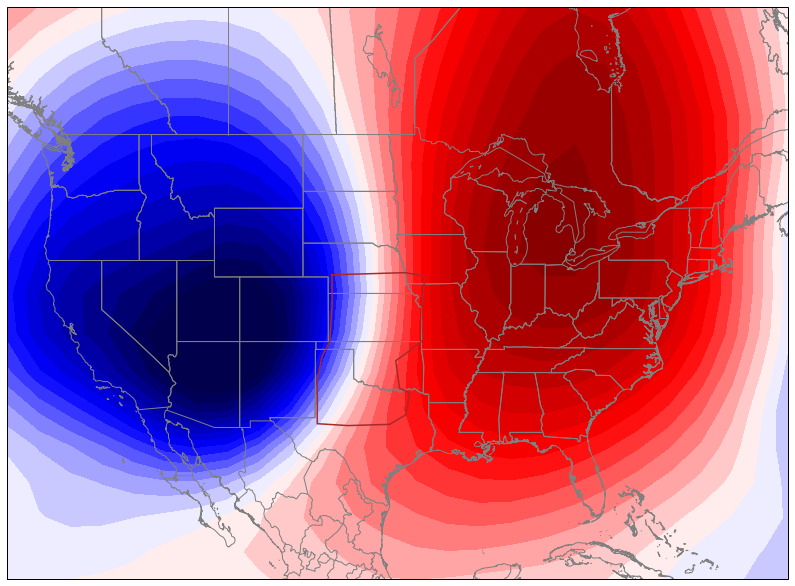

In [11]:
fig = plt.figure(figsize=(14, 14))
bgmap = CartopyMap(bbox=conus, scale='i')
bgmap.draw('default')
bgmap.ax.contourf(composite.lon, composite.lat, composite.hgt, transform=PlateCarree(), 
                  cmap='seismic', levels=np.arange(-140, 150, 10), extend='both')
bgmap.plotlatlons(plainslatlon.lat, plainslatlon.lon, color='brown')